In [68]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys 
base = '/home1/efeghhi/'
sys.path.append(f'{base}ripple_memory/analysis_code/')
from load_data import *
from analyze_data import *
sys.path.append(f'{base}ripple_memory/analysis_code/pac_analyses/')
from load_data_numpy import load_data_np
from comodulogram import remove_session_string, get_filtered_signal

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import decimate, resample

from mne.time_frequency import tfr_array_morlet
from scipy.signal import hilbert
sys.path.append('/home1/efeghhi/ripple_memory/')
from SWRmodule import triangleSmooth

from power_functions import z_score, process_power, load_z_scored_power

from copy import deepcopy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
savePath = f'{base}ripple_memory/analysis_code/power_analyses/john_figures/'

In [41]:
# now let's see which electrodes display a rise in power 
from scipy.stats import ttest_rel 
from scipy.stats import wilcoxon
       
encoding_mode = 1
fs = 500

region_name = ['HPC']
subregion = ['ca1']

freq_band = 'both'
if freq_band == 'medium_gamma':
    freq_range = [[80,120]]
if freq_band == 'low_theta':
    freq_range = [[2,4]]
if freq_band == 'both':
    freq_range = [[2,4], [80,120]]
    
# load data
dd_trials = load_data_np(encoding_mode, region_name=region_name, subregion=subregion)

raw_data = dd_trials['raw']
subj_elec_sess_labels = dd_trials['elec_labels'] 
subj_elec_unique, counts_se = np.unique(subj_elec_sess_labels, return_counts=True)

if encoding_mode:

    # each trial consists of 5 sec of raw data, which starts
    # 1.7 before word onset and ends 3.3 sec after word onset 
    # the data is sampled at 500 Hz
    start_time = -700
    end_time = 2300
    
    start_cutoff = 500
    end_cutoff = 2000
    
else:
       
    # relative to word vocalization, in ms
    start_roi = -1100
    end_roi = -100

    # for recall, 
    # each trial consists of 6 sec of data, centered around word recall 
    start_time = -2000
    end_time = 2000
    
    start_cutoff = 500
    end_cutoff = 2500
    

Loading data
LOADING DATA FROM:  HPC
order: C


In [44]:
raw_data.shape

(61848, 2500)

In [46]:
bandwidth='auto'

fs = 500

# filter signal using hilbert method
filtered_sig = get_filtered_signal(raw_data, freq_range, start_cutoff, 
                                   end_cutoff, fs, bandwidth=bandwidth)
# obtain power and amplitude
filtered_sig_amp = np.real(np.abs(filtered_sig))
filtered_sig_power = process_power(filtered_sig_amp**2, subj_elec_sess_labels)
filtered_sig_power = filtered_sig_power

# update fs and sr_factor
fs = 50
sr_factor = 1000/fs

In [96]:
list_length = 12
semantic_chaining_idxs = []

def compute_semantic_chaining_idxs(recalled_position, cat_list):
    
    '''
    :param list recalled_position: indices of items that were recalled, in the
    order they were recalled
    :param list cat_list: category of each item during encoding (length is
    always the same, equal to list length)
    
    This function returns a list of length cat_list, where recalled elements 
    are assigned a value of 1, recalled and semantically grouped elements 
    are assigned a value of 2, and not recalled items are assigned a value of 0.
    
    This function uses the most liberal definition of a semantically grouped item.
    An item is semantically group if either of its recall neighbors are from the 
    same semantic category. 
    '''
    
    # remove intrusions and duplicates
    recalled_position = [p for p in recalled_position if (p>0) & (p<13)]
    recalled_position = list(dict.fromkeys(recalled_position))
    
    num_recalls = len(recalled_position)
    last_idx = num_recalls - 1
        
    sc_list = [0 for i in range(len(cat_list))]
    
    # if 0 or 1 item was recalled, semantic chaining is not possible
    if len(recalled_position) < 2:
        return sc_list
   
    recalled_categories = []
    for r in recalled_position:
        recalled_categories.append(cat_list[r-1])
        

    for i, (r, rc) in enumerate(zip(recalled_position,recalled_categories)):
        
        if i == 0:
            if recalled_categories[i] == recalled_categories[i+1]:
                sc_list[r-1] = 2
            else:
                sc_list[r-1] = 1
            
        elif (i>0) and (i<last_idx):
            
            if recalled_categories[i] == recalled_categories[i+1]:
                sc_list[r-1] = 2
            elif recalled_categories[i] == recalled_categories[i-1]:
                sc_list[r-1] = 2
            else:
                sc_list[r-1] = 1
            
        elif i == last_idx:
            if recalled_categories[i] == recalled_categories[i-1]:
                sc_list[r-1] = 2
            else:
                sc_list[r-1] = 1

    return sc_list


for elec in np.unique(dd_trials['elec_labels']):
    
    semantic_chaining_elec = []
    
    elec_idxs = np.argwhere(elec==dd_trials['elec_labels']).squeeze()
    
    cat_list_elec = dd_trials['category_array'][elec_idxs]
    recalled_position_elec = dd_trials['position'][elec_idxs]
    correct_elec = dd_trials['correct'][elec_idxs]
    clust_elec = dd_trials['clust_int'][elec_idxs]
    
    num_trials_elec = elec_idxs.shape[0]
    
    for i in range(0, num_trials_elec, list_length):

        cat_list = cat_list_elec[i:i+list_length]

        # encoding positions of recalled items for that list 
        recalled_position = recalled_position_elec[i]

        sc = compute_semantic_chaining_idxs(recalled_position, cat_list)
        semantic_chaining_elec.extend(sc)

    semantic_chaining_idxs.extend(semantic_chaining_elec)

In [100]:
values, counts = np.unique(semantic_chaining_idxs, return_counts=True)
print(values, counts)

[0 1 2] [37532  3903 20413]


In [92]:
cat_list

array(['Clothing', 'Clothing', 'Furniture', 'Furniture', 'Weather',
       'Weather', 'Clothing', 'Clothing', 'Weather', 'Weather',
       'Furniture', 'Furniture'], dtype='<U14')

In [93]:
recalled_position

[1, 2, 8, 3, 11, 12, 7, 10, 9]

In [89]:
for r in recalled_position:
    print(cat_list[r-1])

Clothing
Clothing
Clothing
Furniture
Furniture
Furniture
Clothing
Weather
Weather


In [25]:
dd_trials['position'][0]

[8, 6, 5, 10, 2, 9]

In [20]:
for d_trials['category_array']

array(['Furniture', 'Furniture', 'Furniture', ..., 'Fruit', 'Fruit',
       'Fruit'], dtype='<U14')

In [15]:
dd_trials['clust_int'][]

array([2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0])

In [ ]:
def plot_behavior_power_diff_elec(elec_name, all_elec_idxs, power, correct_idxs, clust_idxs, not_clust_idxs):
    
    
    elec_idxs = np.argwhere(all_elec_idxs==elec_name).squeeze()
    
    clust_elec_idxs = np.intersect1d(elec_idxs, clust_idxs)
    not_clust_elec_idxs = np.intersect1d(elec_idxs, clust_idxs)
    not_recalled_elec_idxs = np.intersect1d(elec_idxs, clust_idxs)
    
    
    power_elec = 
    

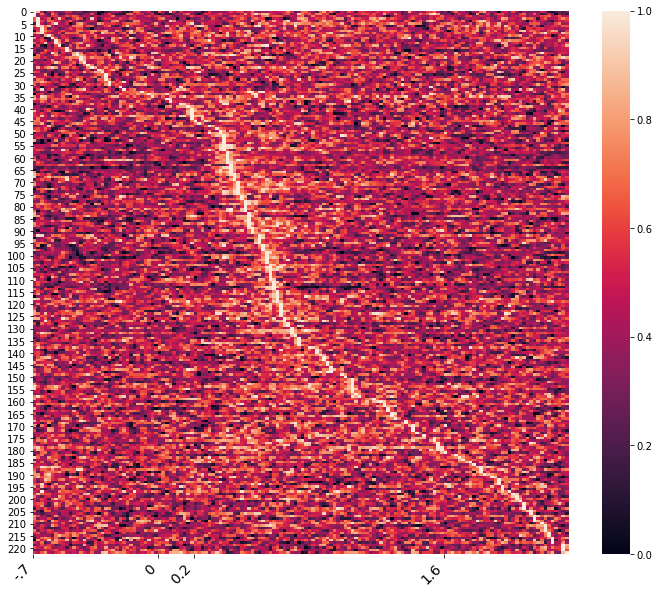

Text(0, 0.5, 'Z-scored medium gamma power')

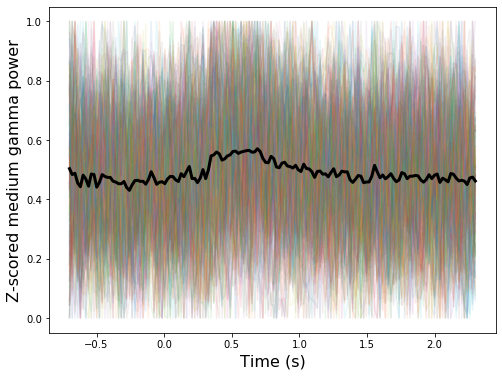

In [8]:
subjects = dd_trials['subj']
across_x_heatmap = []
unique_subjects = np.unique(subjects)
organize_by = subj_elec_sess_labels
filt_pow = filtered_sig_power[1]

# relative to word onset, in ms 
# 512 timepoints so that everything is in a power of 2
start_roi = 100
end_roi = 1124

# convert to indices based on start time and sampling rate factor
start_idx = int((start_roi - start_time)/sr_factor)
end_idx = int((end_roi-start_time)/sr_factor)

s_max = 0
for s in np.unique(organize_by):
    
    s_idxs = np.argwhere(organize_by==s)
    
    s_power = np.mean(filt_pow[s_idxs].squeeze(),axis=0)

    s_power_roi = np.max(s_power[start_idx:end_idx])
    
    if s_power_roi > s_max:
        best_power_elec = s
        s_max = s_power_roi
    
    range_pow = np.max(s_power) - np.min(s_power)
    
    s_pow_norm = (s_power - np.min(s_power))/range_pow
    
    across_x_heatmap.append(s_pow_norm)
    
plt.figure(figsize=(12,10))
across_x_heatmap_np = np.stack(across_x_heatmap)
# Find the index of the maximum value in each row
max_indices = np.argmax(across_x_heatmap_np, axis=1)
# Sort the rows based on the index of the maximum value
sorted_indices = np.argsort(max_indices)
sorted_heatmap = across_x_heatmap_np[sorted_indices]
ax = sns.heatmap(sorted_heatmap)
ax.set_xticks([0, 35, 45, 115])
ax.set_xticklabels(['-.7', '0', '0.2', '1.6'], rotation=45, ha='right', fontsize=14)
plt.show()

plt.figure(figsize=(8,6))
for i, s_data in enumerate(across_x_heatmap_np):
    plt.plot(np.linspace(-.7, 2.3, 150),  s_data, alpha=0.1)
plt.plot(np.linspace(-.7, 2.3, 150), np.mean(across_x_heatmap_np,axis=0), linewidth=3, color='black')
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("Z-scored medium gamma power", fontsize=16)

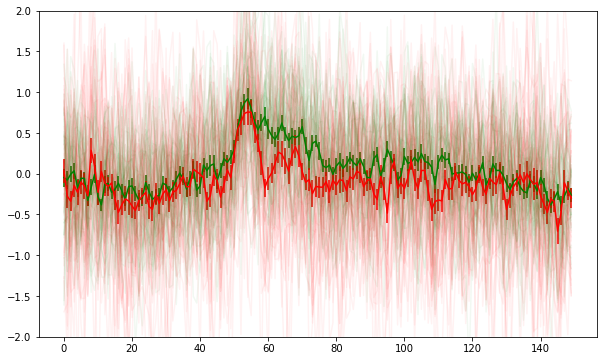

In [131]:
star_elecs = [x for x in subj_elec_sess_labels if 'R1065J' in x]

correct_idxs = np.argwhere(dd_trials['correct']==1).squeeze()
incorrect_idxs = np.argwhere(dd_trials['correct']==0).squeeze()

store_correct = []
store_incorrect = []
plt.figure(figsize=(10,6))
for star_elec in np.unique(star_elecs):
    
    star_elec_idxs = np.argwhere(subj_elec_sess_labels==star_elec).squeeze()
    
    star_elec_idxs_correct = np.intersect1d(star_elec_idxs, correct_idxs)
    star_elec_idxs_incorrect = np.intersect1d(star_elec_idxs, incorrect_idxs)

    
    star_elec_pow_correct = np.mean(filt_pow[star_elec_idxs_correct].squeeze(),axis=0)
    star_elec_pow_incorrect = np.mean(filt_pow[star_elec_idxs_incorrect].squeeze(),axis=0)
    
    store_correct.append(star_elec_pow_correct)
    store_incorrect.append(star_elec_pow_incorrect)
    
    plt.plot(star_elec_pow_correct, color='green', alpha=0.05)
    plt.plot(star_elec_pow_incorrect, color='red', alpha=0.05)


correct_np = np.stack(store_correct)
incorrect_np = np.stack(store_incorrect)
num_elecs = np.unique(star_elecs).shape[0]
    
plt.errorbar(x=np.arange(150), y=np.mean(correct_np,axis=0), yerr=np.std(correct_np,axis=0)/np.sqrt(num_elecs), 
            color='g')
plt.errorbar(x=np.arange(150), y=np.mean(incorrect_np,axis=0), 
             yerr=np.std(incorrect_np,axis=0)/np.sqrt(num_elecs), 
            color='r')
plt.ylim(-2,2)
plt.show()

    